
[GH_DARK] Building figure with background #0d1117...
[GH_DARK] Done!

[WHITE] Building figure with background #ffffff...
[WHITE] Done!


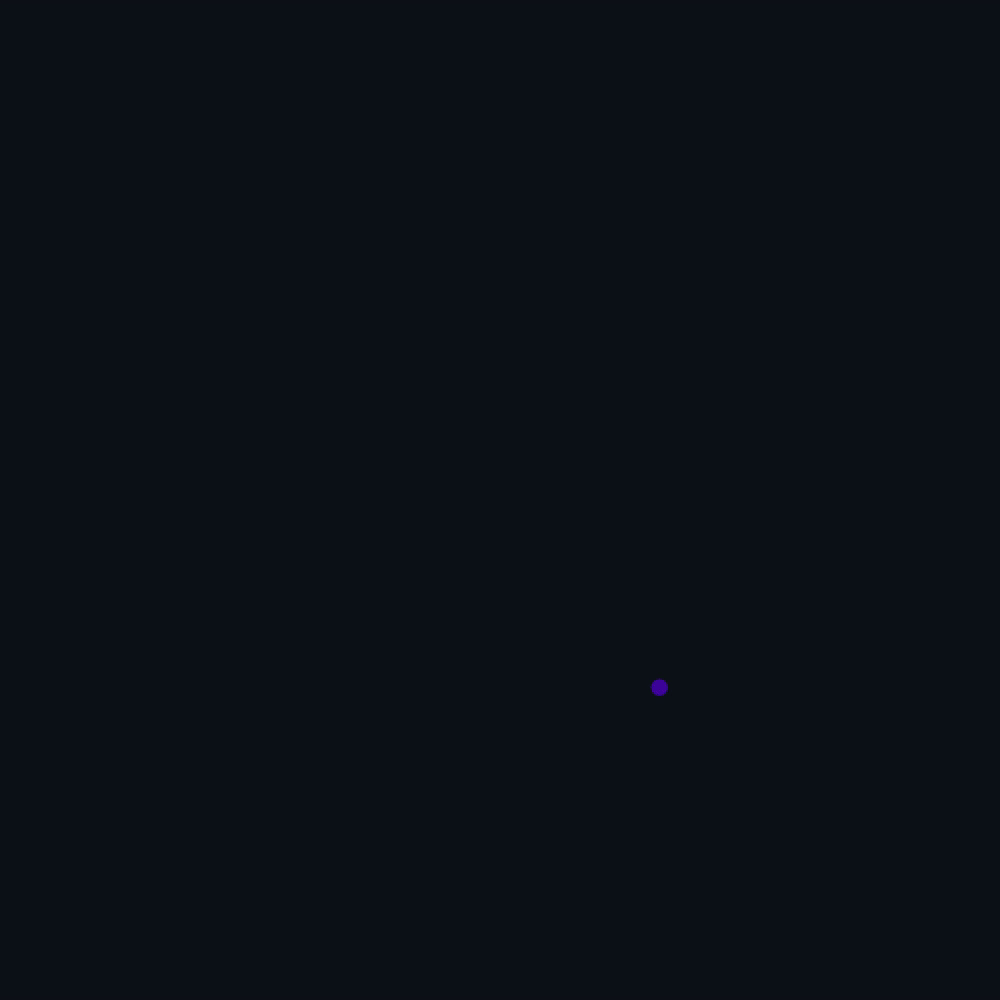

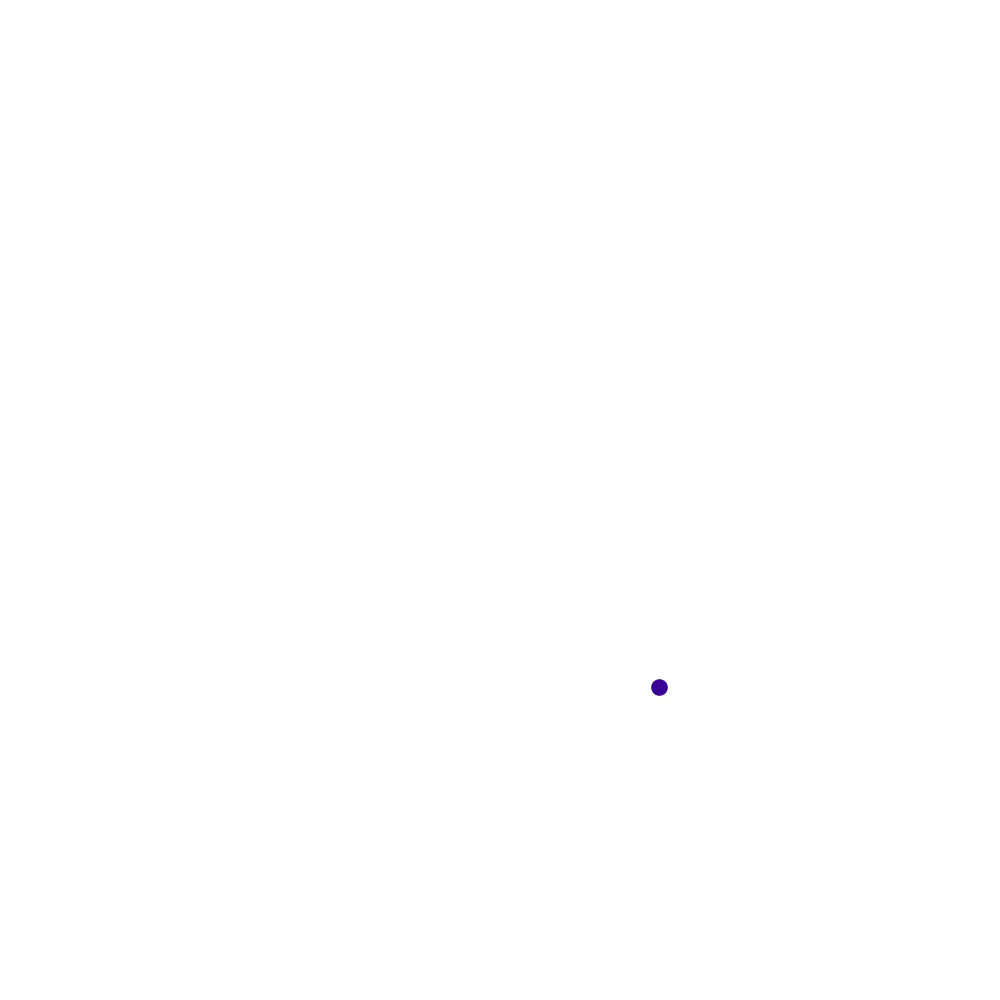

In [1]:
# ==========================================
# ANIMATED 3D PITCH TRAJECTORY — 1x LOOP & GIF
# • Two Themes: GitHub Dark Mode & Pure White
# • No axes, labels, grid, or text (except node label)
# • Live dynamic frequency label (e.g., "1.3k")
# • 1× loop (original duration)
# • Renders synced MP4s and identical GIFs
# ==========================================

import librosa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Video, Image, display, HTML
import os
from scipy.interpolate import interp1d

# ── 1. Download Audio ─────────────────────────────────────────────────────────

url = (
    "https://raw.githubusercontent.com/ronniross/biosignal-translator/main/taxonomy/"
    "cellular-life/eukarya/animalia/chordata/vertebrata/avians/passeriformes/passeri/"
    "parulidae/parkesia/parkesia-noveboracensis-northern-waterthrush/"
    "northern-naterthrush-1.wav"
)
file_name = "northern-waterthrush.wav"
if not os.path.exists(file_name):
    os.system(f"wget -q '{url}' -O {file_name}")

# ── 2. Audio Analysis ────────────────────────────────────────────────────────

y, sr = librosa.load(file_name, sr=None)
duration = librosa.get_duration(y=y, sr=sr)
hop_length = 512

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, hop_length=hop_length)
S_db = librosa.power_to_db(S, ref=np.max)
times = librosa.frames_to_time(np.arange(S_db.shape[1]), sr=sr, hop_length=hop_length)
frequencies = librosa.mel_frequencies(n_mels=256, fmin=50.0, fmax=sr / 2)

peak_freq_indices = np.argmax(S_db, axis=0)
peak_freqs = frequencies[peak_freq_indices]
peak_amps  = np.max(S_db, axis=0)

# ── 3. Map Frequency → Fixed 3D Position ─────────────────────────────────────

f_min, f_max = frequencies.min(), frequencies.max()
norm_f = (peak_freqs - f_min) / (f_max - f_min + 1e-9)   # 0..1

# Spiral layout
angle  = norm_f * 4 * np.pi          # 2 full rotations across freq range
radius = 0.3 + norm_f * 0.7          # 0.3 .. 1.0

x_pos = radius * np.cos(angle)
y_pos = radius * np.sin(angle)
z_pos = peak_amps                    # dB value (≤ 0)

# Silence mask
mask  = peak_amps > -55
t_raw = times[mask]
x_raw = x_pos[mask]
y_raw = y_pos[mask]
z_raw = z_pos[mask]
f_raw = peak_freqs[mask]
a_raw = peak_amps[mask]

# ── 4. Build data arrays (1x Duration) ──────────────────────────────────────

t_data = t_raw; x_data = x_raw; y_data = y_raw
z_data = z_raw; f_data = f_raw; a_data = a_raw
total_dur = duration

# Target ~25 fps for smooth visuals
FPS = 25
n_frames = int(total_dur * FPS)
frame_times = np.linspace(0, total_dur, n_frames)

def safe_interp(arr, src_t, dst_t):
    f = interp1d(src_t, arr, kind='linear', bounds_error=False,
                 fill_value=(arr[0], arr[-1]))
    return f(dst_t)

xi = safe_interp(x_data, t_data, frame_times)
yi = safe_interp(y_data, t_data, frame_times)
zi = safe_interp(z_data, t_data, frame_times)
fi = safe_interp(f_data, t_data, frame_times)
ai = safe_interp(a_data, t_data, frame_times)

# Calculate fixed axis limits so cameras stay identical
xl, yl = max(abs(xi)) + 0.1, max(abs(yi)) + 0.1
z_min, z_max = min(zi) - 3, 2

# ── 5. Generation Function for Themes ────────────────────────────────────────

def render_theme(prefix, bg_color, core_color, text_color, flare_cmap, ghost_a, glow_a):
    print(f"\n[{prefix.upper()}] Building figure with background {bg_color}...")

    plt.style.use('default')
    fig = plt.figure(figsize=(10, 10), facecolor=bg_color)
    ax  = fig.add_subplot(111, projection='3d', facecolor=bg_color)

    # Strip EVERYTHING visible except the data
    ax.xaxis.pane.fill = False; ax.xaxis.pane.set_edgecolor('none')
    ax.yaxis.pane.fill = False; ax.yaxis.pane.set_edgecolor('none')
    ax.zaxis.pane.fill = False; ax.zaxis.pane.set_edgecolor('none')
    ax.grid(False)
    ax.xaxis._axinfo["grid"]["color"] = (0,0,0,0)
    ax.yaxis._axinfo["grid"]["color"] = (0,0,0,0)
    ax.zaxis._axinfo["grid"]["color"] = (0,0,0,0)
    ax.set_axis_off()

    ax.set_xlim(-xl, xl)
    ax.set_ylim(-yl, yl)
    ax.set_zlim(z_min, z_max)

    # Plot elements
    GHOST_LEN, GLOW_LEN, CORE_LEN = 120, 50, 15
    ghost, = ax.plot([], [], [], lw=5,  color='#4400cc', alpha=ghost_a)
    glow,  = ax.plot([], [], [], lw=3,  color='#9933ff', alpha=glow_a)
    core,  = ax.plot([], [], [], lw=1.5,color=core_color, alpha=0.85)

    dot = ax.scatter([], [], [], s=120, c=[], cmap='plasma',
                     vmin=f_data.min(), vmax=f_data.max(),
                     depthshade=False, zorder=10)

    flare = ax.scatter([], [], [], s=[], c=[], cmap=flare_cmap,
                       vmin=0, vmax=1, alpha=0.5, depthshade=False, zorder=9)

    freq_text = ax.text(0, 0, 0, "", zdir=None, color=text_color,
                        fontsize=18, weight='bold', ha='center', va='bottom', zorder=15)

    def update(num):
        n = max(num, 1)
        g0, e0, c0 = max(0, n - GHOST_LEN), max(0, n - GLOW_LEN), max(0, n - CORE_LEN)

        ghost.set_data(xi[g0:n], yi[g0:n]); ghost.set_3d_properties(zi[g0:n])
        glow.set_data(xi[e0:n], yi[e0:n]);  glow.set_3d_properties(zi[e0:n])
        core.set_data(xi[c0:n], yi[c0:n]);  core.set_3d_properties(zi[c0:n])

        dot._offsets3d = (xi[c0:n], yi[c0:n], zi[c0:n])
        dot.set_array(fi[c0:n])

        loud = np.clip((ai[n-1] + 55) / 55, 0, 1)
        burst_size = loud ** 2 * 800
        flare._offsets3d = ([xi[n-1]], [yi[n-1]], [zi[n-1]])
        flare.set_array([loud])
        flare.set_sizes([burst_size])

        if loud > 0.05:
            freq_text.set_text(f"{fi[n-1]/1000:.1f}k")
        else:
            freq_text.set_text("")

        freq_text.set_position((xi[n-1], yi[n-1]))
        freq_text.set_3d_properties(zi[n-1] + 3.0, zdir=None)
        ax.view_init(elev=28, azim=num * (120 / n_frames))
        return ghost, glow, core, dot, flare, freq_text

    # Render MP4 (Silent)
    silent_path = f'{prefix}_silent.mp4'
    ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=1000/FPS, blit=False)
    ani.save(silent_path, writer='ffmpeg', fps=FPS, savefig_kwargs={'facecolor': bg_color},
             extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p', '-crf', '18'])
    plt.close(fig)

    # Mux Audio
    final_mp4 = f'{prefix}_final.mp4'
    os.system(f"ffmpeg -y -i {silent_path} -i {file_name} -c:v copy -c:a aac -b:a 192k -shortest {final_mp4} -loglevel quiet")

    # Render GIF
    final_gif = f'{prefix}_final.gif'
    os.system(f"ffmpeg -y -i {final_mp4} -vf \"split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse\" -loop 0 {final_gif} -loglevel quiet")

    print(f"[{prefix.upper()}] Done!")
    return final_mp4, final_gif

# ── 6. Render the Two Themes ─────────────────────────────────────────────────

# Theme 1: GitHub Dark Mode
gh_mp4, gh_gif = render_theme(
    prefix='gh_dark',
    bg_color='#0d1117',
    core_color='#ffffff',
    text_color='white',
    flare_cmap='hot',
    ghost_a=0.07,
    glow_a=0.22
)

# Theme 2: White Mode
# Using darker cores, darker text, and plasma flare to stand out on pure white
w_mp4, w_gif = render_theme(
    prefix='white',
    bg_color='#ffffff',
    core_color='#333333',
    text_color='black',
    flare_cmap='plasma',
    ghost_a=0.15,  # Slightly higher alpha to show up well against white
    glow_a=0.35
)

# ── 7. Display 4 Outputs in Colab ────────────────────────────────────────────

display(HTML("<h2>1. GitHub Dark Mode (#0d1117) - Video</h2>"))
display(Video(gh_mp4, embed=True, html_attributes="controls autoplay loop"))

display(HTML("<h2>2. GitHub Dark Mode - GIF</h2>"))
display(Image(filename=gh_gif))

display(HTML("<hr><h2>3. Pure White Background (#ffffff) - Video</h2>"))
display(Video(w_mp4, embed=True, html_attributes="controls autoplay loop"))

display(HTML("<h2>4. Pure White Background - GIF</h2>"))
display(Image(filename=w_gif))